In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import pickle
import cvxpy 
from cvxpy import *
from  sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv
import sys
import networkx as nx
from robust_KO_learning import *
from preprocessing import *
from gene_sets import *

In [2]:
plt.rcParams.update({'font.size':18})
# plt.rcParams.update({'text.usetex' : True})
figDir = '/Users/aqib/Desktop/BCCL/structured-dmd/NSBA_submission/figures/'
my_cmap = sns.diverging_palette(15, 221, s=99, sep=1, l=45, center='light',as_cmap=True)
# sns.choose_diverging_palette()
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

In [4]:
# Load TPM or GeTMM dataframe (results are identical, implying GeTMM normalization is unnecessary for our dataset)
df_tpm_filter = pd.read_csv('data/TPM_matrix_NAND.csv') 
# get list of samples that are to be removed because they don't have a timepoint pair, 
# i.e. a col in Xp does not have corresponding col in Xf or vice versa
unpaired_samples = get_unpaired_samples(df_tpm_filter)
# get gene names
all_genes_filter =  df_tpm_filter['gene'] 
# remove 'gene' col from df
df_tpm_filter = df_tpm_filter.iloc[:,1:]
# drop the unpaired samples
df_tpm_filter = df_tpm_filter.drop(columns=unpaired_samples).reset_index(drop=True)

# path to deseq results for gene downselection 
res_dir_list = ['data/condition_nand00375_vs_wt00375_results.csv',\
                'data/condition_nand003718_vs_wt003718_results.csv']

# get all snapshots keyed in the following way: 
# [strain][temperature][inducer][snapshots]
snapshot_dict = snapshots_from_df(df_tpm_filter)

# the strains are ['wt','icar','phlf','nand']
# the temperatures are ['30','37']
# the inducers are ['00','10','01','11'] ([arabinose,iptg])
# the snapshots are ['Yp','Yf']

# get circuit gene names and indices
circuit_inds = list(range(13)) # circuit genes are in first 13 rows of df
circuit_genes = all_genes_filter[:13]

# select genes for modeling
ara_lac = 0 # 13 ara and lac genes
rpoS_genes = 0 # rpoS and known regulated genes
acrR_genes = 0 # acrR and known regulated genes
argR_genes = 0 # argR and known regulated genes
xylR_genes = 0
lac_xyl = 0
# see: https://www.weizmann.ac.il/mcb/UriAlon/e-coli-transcription-network#:~:text=E.-,coli%20transcription%20network,in%20cells%20orchestrate%20gene%20expression.&text=Each%20network%20motif%20has%20a,responses%20to%20fluctuating%20external%20signals.
de_only = 1 # only differentially expressed genes

# get host gene names and indices
if ara_lac:
    p_thresh, fc_thresh = 'n/a', 'n/a'
    my_genes,  my_inds  = get_ara_lac_genes(all_genes_filter) # only ara and lac genes, want to create more smaller networks like this:
    selected_genes = 'ara_lac'
elif rpoS_genes: 
    p_thesh, fc_thresh = 'n/a', 'n/a'
    my_genes, my_inds = get_rpoS_genes(all_genes_filter)
    selected_genes = 'rpoS_genes'
elif acrR_genes: 
    p_thesh, fc_thresh = 'n/a', 'n/a'
    my_genes, my_inds = get_acrR_genes(all_genes_filter)
    selected_genes = 'acrR_genes'
elif argR_genes: 
    p_thesh, fc_thresh = 'n/a', 'n/a'
    my_genes, my_inds = get_argR_genes(all_genes_filter)
    selected_genes = 'argR_genes'
elif xylR_genes: 
    p_thesh, fc_thresh = 'n/a', 'n/a'
    my_genes, my_inds = get_xylR_genes(all_genes_filter)
    selected_genes = 'xylR_genes'
if lac_xyl:
    p_thresh, fc_thresh = 'n/a', 'n/a'
    my_genes,  my_inds  = get_lac_xyl_genes(all_genes_filter) # only ara and lac genes, want to create more smaller networks like this:
    selected_genes = 'lac_xyl'
elif de_only: 
#     p_thresh, fc_thresh = 0.05, 2
    p_thresh, fc_thresh = 0.001, 2.5
    my_genes, my_inds = get_DE_genes(res_dir_list,all_genes_filter,p_thresh=p_thresh,fc_thresh=fc_thresh)
    selected_genes = 'de_only'
print(len(my_genes), 'genes kept for modeling.')

    
TEMP = '37'
NOISE_SCALER = 1.0 # scale the bounded uncertainty set dU
VERBOSE = True # print optimization log from the scs solver
# save state-space model
doSave = False
fn = 'x8_NAND' # name to save pickle file as, will also be used as id for run

# ensure unique filename/id is being used for the run
if doSave: 
    prev_ids = pd.read_csv('data/run_log.csv')['id']
    if fn in list(prev_ids):
        sys.exit("The id (fn) being used already exists in run_log.csv. Provide a unique name and retry.")
        

298 genes kept for modeling.


In [5]:
my_genes

['adeP',
 'adhP',
 'aidB',
 'alaE',
 'alx',
 'ampG',
 'amyA',
 'aroF',
 'aroH',
 'aroP',
 'asnA',
 'asr',
 'astA',
 'astB',
 'astC',
 'astD',
 'bdm',
 'bhsA',
 'blc',
 'bolA',
 'borD',
 'bssR',
 'cirA',
 'clpA',
 'cpxP',
 'csgD',
 'csgE',
 'csgF',
 'csgG',
 'csiD',
 'cspA',
 'curA',
 'cvpA',
 'cyoB',
 'cyoC',
 'dacD',
 'dctA',
 'degP',
 'dkgA',
 'dosC',
 'dppB',
 'dppC',
 'dppD',
 'dppF',
 'dps',
 'dtpA',
 'dusB',
 'elaB',
 'emrD',
 'entD',
 'envZ',
 'fadL',
 'fbaB',
 'fdoG',
 'fdoH',
 'fecB',
 'fecC',
 'fecE',
 'fepA',
 'fic',
 'fis',
 'fiu',
 'flgB',
 'flgC',
 'flgD',
 'flgE',
 'flgF',
 'flgG',
 'flgH',
 'flgI',
 'flgJ',
 'flhC',
 'flhD',
 'fliA',
 'fliF',
 'fliG',
 'fliH',
 'fliI',
 'fliL',
 'fliM',
 'fliN',
 'fucO',
 'gabD',
 'gabP',
 'gabT',
 'gadA',
 'gadB',
 'gadC',
 'gadE',
 'gatA',
 'gatB',
 'gatD',
 'gatZ',
 'glnA',
 'glpA',
 'glpB',
 'glpC',
 'glpD',
 'glpT',
 'gltF',
 'gpt',
 'grcA',
 'greB',
 'gudX',
 'hchA',
 'hdeB',
 'hdeD',
 'hdhA',
 'hsdS',
 'ibpB',
 'infA',
 'lamB',
 

#### Structured learning sequence:
- 0) Learn host dynamics from wild type 
- 1) Learn single inducer impact on host (arabinose and iptg separate)
- 2) Learn control matrix that accounts for PhlF gate + arabinose dynamics
- 3) Learn control matrix that accounts for IcaR gate + IPTG dynamics
- 4) Learn control matrix that accounts for NAND circuit + arabinose + iptg + phlf + nand

In [5]:
################# Wild type dynamics ###################################
Yp = snapshot_dict['wt'][TEMP]['00']['Yp']
Yf = snapshot_dict['wt'][TEMP]['00']['Yf']
# normalize each snapshot to have unit norm, a dynamics preserving transformation
Yp_normed, Yf_normed = apply_normalizer(Yp,Yf)
# Yp_normed, Yf_normed = apply_biased_StandardScaler(Yp,Yf)
# Yp_normed, Yf_normed = apply_MinMaxScaler(Yp,Yf)
# Yp_normed, Yf_normed = Yp, Yf
Yp_normed, Yf_normed = Yp_normed[my_inds], Yf_normed[my_inds]
# Yp_normed, Yf_normed = np.vstack((0.0001*np.ones((1,Yp_normed.shape[1])),Yp_normed)), np.vstack((0.0001*np.ones((1,Yf_normed.shape[1])),Yf_normed))
# compute the intrareplicate noise for regularizing K as motivated by Robust DMD
lambda_val_vec_p = np.std(Yp_normed,axis=1)[:,np.newaxis]
lambda_val_vec_f = np.std(Yf_normed,axis=1)[:,np.newaxis]
lambda_val_vec = np.std(np.hstack((lambda_val_vec_p,lambda_val_vec_f)),axis=1)[:,np.newaxis]
# lambda_val_vec = lambda_val_vec_p
# K = calc_Koopman(Yf_normed,Yp_normed,flag=2,lambda_val=lambda_val_vec,\
#     noise_scaler=NOISE_SCALER,verbose=VERBOSE)
K = calc_Koopman(Yf_normed,Yp_normed,flag=3,lambda_val=lambda_val_vec,\
    noise_scaler=NOISE_SCALER,verbose=VERBOSE)
# K = calc_Koopman(Yf_normed,Yp_normed,flag=4,lambda_val=lambda_val_vec,\
#       noise_scaler=NOISE_SCALER,lambda_val_1=0.1,verbose=VERBOSE)

L2,2 Regularization
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 4), (13, 4)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1370
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 206
Cones:	soc vars: 53, soc blks: 1
	sd vars: 153, sd blks: 1
Setup time: 4.25e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 5.99e-03  7.41e-01  8.18e-04 -8.11e-04  7.65e-06  8.03e-19  1.30e-02 
    15| 1.61e-13  5.89e-12  4.17e-14 -3.89e-14  2.

In [79]:
################# WT + arabinose dynamics ###################################
Yp = snapshot_dict['wt'][TEMP]['10']['Yp']
Yf = snapshot_dict['wt'][TEMP]['10']['Yf']
# normalize each snapshot to have unit norm, a dynamics preserving transformation
Yp_normed, Yf_normed = apply_normalizer(Yp,Yf)
Yp_normed, Yf_normed = Yp_normed[my_inds], Yf_normed[my_inds]
# treat arabinose as a step input to the system 
Uara = (Yp_normed.max() - Yf_normed.min())/2 * np.ones((1,Yp_normed.shape[1]))
# the scaling coefficient is to have mag of step be on same scale as the data
# compute the intrareplicate noise for regularizing K as motivated by Robust DMD
lambda_val_vec = np.std(Uara,axis=1)[:,np.newaxis]
# form the LHS of the optimization problem
LHS = Yf_normed  - K@Yp_normed
Kara = calc_input_Koopman(LHS,Uara,flag=2,lambda_val=lambda_val_vec,\
    noise_scaler=NOISE_SCALER,verbose=VERBOSE)

################# WT + IPTG dynamics ###################################
Yp = snapshot_dict['wt'][TEMP]['01']['Yp']
Yf = snapshot_dict['wt'][TEMP]['01']['Yf']
# normalize each snapshot to have unit norm, a dynamics preserving transformation
Yp_normed, Yf_normed = apply_normalizer(Yp,Yf)
Yp_normed, Yf_normed = Yp_normed[my_inds], Yf_normed[my_inds]
# treat arabinose as a step input to the system 
Uiptg = (Yp_normed.max() - Yf_normed.min())/2 * np.ones((1,Yp_normed.shape[1]))
# the scaling coefficient is to have mag of step be on same scale as the data
# compute the intrareplicate noise for regularizing K as motivated by Robust DMD
lambda_val_vec = np.std(Uiptg,axis=1)[:,np.newaxis]
# form the LHS of the optimization problem
LHS = Yf_normed  - K@Yp_normed
Kiptg = calc_input_Koopman(LHS,Uiptg,flag=2,lambda_val=lambda_val_vec,\
    noise_scaler=NOISE_SCALER,verbose=VERBOSE)

################# PhlF Gate + arabinose dynamics (actually IPTG?) ###################################
Yp = snapshot_dict['phlf'][TEMP]['01']['Yp'] # actually IPTG?
Yf = snapshot_dict['phlf'][TEMP]['01']['Yf']
# normalize each snapshot to have unit norm, a dynamics preserving transformation
Yp_normed, Yf_normed = apply_normalizer(Yp,Yf)
Uphlf_p, Uphlf_f = Yp_normed[circuit_inds], Yf_normed[circuit_inds]
Yp_normed, Yf_normed = Yp_normed[my_inds], Yf_normed[my_inds]
# compute the intrareplicate noise for regularizing K as motivated by Robust DMD
lambda_val_vec_p = np.std(Uphlf_p,axis=1)[:,np.newaxis]
lambda_val_vec_f = np.std(Uphlf_f,axis=1)[:,np.newaxis]
lambda_val_vec = np.std(np.hstack((lambda_val_vec_p,lambda_val_vec_f)),axis=1)[:,np.newaxis]
# if number of samples in Yp/Yf do not match the number of  samples in the 
# previously used step inputs, simply downselect the step input as we do here
# form the LHS of the optimization problem
LHS = Yf_normed  - K@Yp_normed - Kara@Uara[:,:-1]
Kphlf = calc_input_Koopman(LHS,Uphlf_p,flag=2,lambda_val=lambda_val_vec,\
    noise_scaler=NOISE_SCALER,verbose=VERBOSE)

################# IcaR Gate + IPTG dynamics ###################################
Yp = snapshot_dict['icar'][TEMP]['01']['Yp']
Yf = snapshot_dict['icar'][TEMP]['01']['Yf']
# normalize each snapshot to have unit norm, a dynamics preserving transformation
Yp_normed, Yf_normed = apply_normalizer(Yp,Yf)
Uicar_p, Uicar_f = Yp_normed[circuit_inds], Yf_normed[circuit_inds]
Yp_normed, Yf_normed = Yp_normed[my_inds], Yf_normed[my_inds]
# compute the intrareplicate noise for regularizing K as motivated by Robust DMD
lambda_val_vec_p = np.std(Uicar_p,axis=1)[:,np.newaxis]
lambda_val_vec_f = np.std(Uicar_f,axis=1)[:,np.newaxis]
lambda_val_vec = np.std(np.hstack((lambda_val_vec_p,lambda_val_vec_f)),axis=1)[:,np.newaxis]
# if number of samples in Yp/Yf do not match the number of  samples in the 
# previously used step inputs, simply downselect the step input as we do here
# this will only be an issue with the manually defined step inputs
# form the LHS of the optimization problem
if TEMP == '37':
    LHS = Yf_normed  - K@Yp_normed - Kiptg@Uiptg[:,:-1]
elif TEMP == '30':
    LHS = Yf_normed  - K@Yp_normed - Kiptg@np.hstack((Uiptg,Uiptg[:,0:1]))
Kicar = calc_input_Koopman(LHS,Uicar_p,flag=2,lambda_val=lambda_val_vec,\
    noise_scaler=NOISE_SCALER,verbose=VERBOSE)

########## NAND Circuit + arabinose + IPTG + Phlf Gate + Icar Gate dynamics ###################################
Yp = snapshot_dict['nand'][TEMP]['11']['Yp']
Yf = snapshot_dict['nand'][TEMP]['11']['Yf']
# normalize each snapshot to have unit norm, a dynamics preserving transformation
Yp_normed, Yf_normed = apply_normalizer(Yp,Yf)
Unand_p, Unand_f = Yp_normed[circuit_inds], Yf_normed[circuit_inds]
Yp_normed, Yf_normed = Yp_normed[my_inds], Yf_normed[my_inds]
# compute the intrareplicate noise for regularizing K as motivated by Robust DMD
lambda_val_vec_p = np.std(Unand_p,axis=1)[:,np.newaxis]
lambda_val_vec_f = np.std(Unand_f,axis=1)[:,np.newaxis]
lambda_val_vec = np.std(np.hstack((lambda_val_vec_p,lambda_val_vec_f)),axis=1)[:,np.newaxis]
# form the LHS of the optimization problem
if TEMP == '37':
    LHS = Yf_normed  - K@Yp_normed - Kiptg@Uiptg - Kara@Uara  - \
        Kphlf@Unand_p - Kicar@Unand_p
elif TEMP == '30':
    LHS = Yf_normed  - K@Yp_normed - Kiptg@Uiptg \
        - Kara@Uara[:,:-1]  - Kphlf@Unand_p - Kicar@Unand_p
Knand = calc_input_Koopman(LHS,Unand_p,flag=2,lambda_val=lambda_val_vec,\
    noise_scaler=NOISE_SCALER,verbose=VERBOSE)

[INFO]: CVXPY Koopman operator variable: (298, 1)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1495
eps = 1.00e-04, alpha = 1.50, max_iters = 20000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 300, constraints m = 46946
Cones:	soc vars: 1193, soc blks: 1
	sd vars: 45753, sd blks: 1
Setup time: 9.77e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.03e-01  2.45e+01  8.06e-01 -1.44e-02  4.14e+00  2.44e-15  1.64e-02 
   100| 4.29e-01  2.25e+00  9.43e-01  1.65e+01 -0.00e+00  0.00e+00  1.15e+00 
   200| 3.38e-01  3.38e+01  9.76e

    14| 9.05e-12  1.75e-10  2.39e-12  5.39e-13 -1.86e-12  1.23e-16  4.80e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 4.80e-01s
	Lin-sys: nnz in L factor: 75854, avg solve time: 2.54e-04s
	Cones: avg projection time: 2.74e-02s
	Acceleration: avg step time: 3.28e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 8.3883e-13, dist(y, K*) = 3.1445e-09, s'y/|s||y| = 2.4163e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 9.0506e-12
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.7548e-10
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.3948e-12
----------------------------------------------------------------------------
c'x = 0.0000, -b'y = -0.0000
[INFO]: CVXPY problem status: optimal
MSE =  8.745e-26

 

[INFO]: CVXPY Koopman operator variable: (298, 13)
WARN: A->p (column pointers) not strictly increasing, column 2684 empty
WARN: A->p (column pointers) not strictly 

    11| 3.19e-12  1.87e-10  2.12e-13  6.52e-15 -2.05e-13  7.50e-17  4.12e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 4.12e-01s
	Lin-sys: nnz in L factor: 76152, avg solve time: 2.68e-04s
	Cones: avg projection time: 2.95e-02s
	Acceleration: avg step time: 3.52e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 6.4327e-13, dist(y, K*) = 2.0114e-09, s'y/|s||y| = 1.7029e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 3.1914e-12
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.8701e-10
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.1171e-13
----------------------------------------------------------------------------
c'x = 0.0000, -b'y = -0.0000
[INFO]: CVXPY problem status: optimal
MSE =  1.043e-28

 

[INFO]: CVXPY Koopman operator variable: (298, 13)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver


In [ ]:
if doSave: 
    pickle.dump([K,Kara,Kiptg,Kphlf,Kicar,Knand,my_genes,my_inds],open('data/'+fn+'.pkl','wb'))
    df = pd.DataFrame({'id':[fn],'n_genes':[len(my_genes)],'padj_thresh':[p_thresh],'fc_thresh':[fc_thresh],\
                        'selected_genes':selected_genes,'noise_scaler':NOISE_SCALER,'temp':TEMP})
    # before writing to run_log, need to start newline
    with open('data/run_log.csv', 'a') as f:
        f.write('\n')
    df.to_csv('data/run_log.csv', mode='a', index=False, header=False)

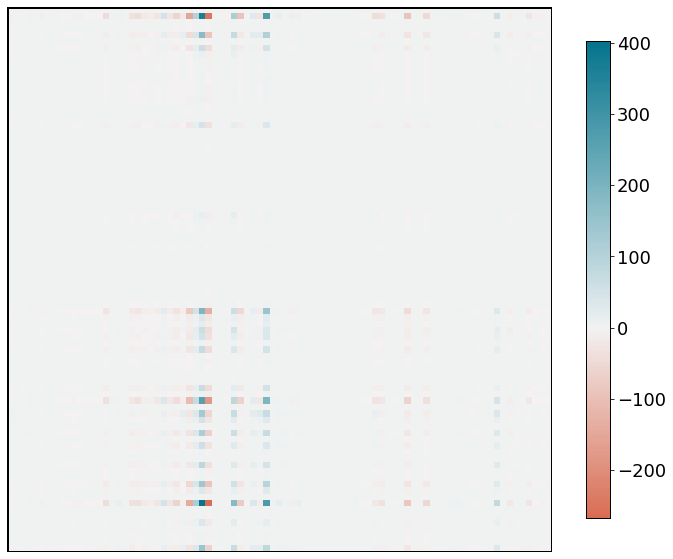

In [21]:
######## Visualize host-interactions as heatmap ############
SAVEFIG = False
SAVEDIR = figDir+'fig1/Khost1137_ara-lac.pdf'
FIGSIZE = (10,10)
CBARSHRINK = 0.7
ik,fk = 0, K.shape[1]
# XLAB, YLAB = ['bias'] + my_genes, ['bias'] + my_genes
# ik,fk = 0, 30
if ik == 0 and fk == K.shape[1]:
    XLAB, YLAB = [], []
else: 
    XLAB,YLAB = my_genes[ik:fk],my_genes[ik:fk]    
if len(my_genes) < 30: 
        XLAB, YLAB = my_genes, my_genes

koopman_heatmap(K[ik:fk,ik:fk],FIGSIZE,XLAB,YLAB,CBARSHRINK,savefig=SAVEFIG,savedir=SAVEDIR)
# print(mean_squared_error(Yf_normed,K@Yp_normed), r2_score(Yf_normed,K@Yp_normed))

In [17]:
impacted_genes = np.linalg.norm(K,axis=1,ord=2)

<AxesSubplot:>

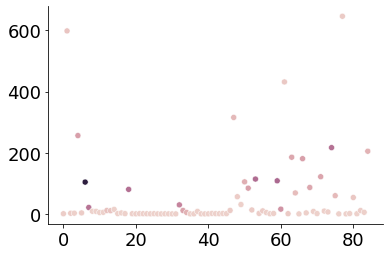

In [18]:
sns.scatterplot(x=list(range(len(impacted_genes))),y=impacted_genes,
                hue=(np.hstack((Yp_normed,Yf_normed)).mean(axis=1)),legend=False)

In [19]:
affector_genes = np.linalg.norm(K,axis=0,ord=2)

<AxesSubplot:>

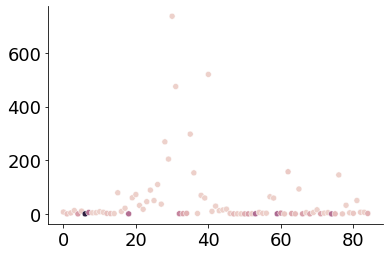

In [20]:
sns.scatterplot(x=list(range(len(affector_genes))),y=affector_genes,
                hue=(np.hstack((Yp_normed,Yf_normed)).mean(axis=1)),legend=False)

#### Circuit and Host impact joint analysis

In [26]:
################# Wild type dynamics with inducers ###################################
NOISE_SCALER = 10.0
Yp = snapshot_dict['wt'][TEMP]['11']['Yp']
Yf = snapshot_dict['wt'][TEMP]['11']['Yf']
# normalize each snapshot to have unit norm, a dynamics preserving transformation
Yp_normed, Yf_normed = apply_normalizer(Yp,Yf)
# Yp_normed, Yf_normed = apply_biased_StandardScaler(Yp,Yf)
# Yp_normed, Yf_normed = apply_MinMaxScaler(Yp,Yf)
# Yp_normed, Yf_normed = Yp, Yf
Yp_normed, Yf_normed = Yp_normed[my_inds], Yf_normed[my_inds]
# Yp_normed, Yf_normed = np.vstack((0.0001*np.ones((1,Yp_normed.shape[1])),Yp_normed)), np.vstack((0.0001*np.ones((1,Yf_normed.shape[1])),Yf_normed))
# compute the intrareplicate noise for regularizing K as motivated by Robust DMD
lambda_val_vec_p = np.std(Yp_normed,axis=1)[:,np.newaxis]
lambda_val_vec_f = np.std(Yf_normed,axis=1)[:,np.newaxis]
lambda_val_vec = np.std(np.hstack((lambda_val_vec_p,lambda_val_vec_f)),axis=1)[:,np.newaxis]
# lambda_val_vec = lambda_val_vec_p
# K = calc_Koopman(Yf_normed,Yp_normed,flag=2,lambda_val=lambda_val_vec,\
#     noise_scaler=NOISE_SCALER,verbose=VERBOSE)
K = calc_Koopman(Yf_normed,Yp_normed,flag=3,lambda_val=lambda_val_vec,\
    noise_scaler=NOISE_SCALER,verbose=VERBOSE)
# K = calc_Koopman(Yf_normed,Yp_normed,flag=4,lambda_val=lambda_val_vec,\
#       noise_scaler=NOISE_SCALER,lambda_val_1=0.1,verbose=VERBOSE)

L2,2 Regularization
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.15e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.80e-01  1.27e+00  2.27e-01 -2.92e-01  1.82e-03  1.17e-16  1.20e-03 
    12| 1.59e-11  5.20e-11  3.80e-12  9.14e-13 -2.

In [27]:
########## Retroactivity and Impact on Host ####################################
Yp = snapshot_dict['nand'][TEMP]['11']['Yp']
Yf = snapshot_dict['nand'][TEMP]['11']['Yf']
# normalize each snapshot to have unit norm, a dynamics preserving transformation
Yp_normed, Yf_normed = apply_normalizer(Yp,Yf)
Yp_normed, Yf_normed = Yp_normed[circuit_inds+my_inds], Yf_normed[circuit_inds+my_inds]
#  compute the intrareplicate noise for regularizing K as motivated by Robust DMD
lambda_val_vec_p = np.std(Yp_normed,axis=1)[:,np.newaxis]
lambda_val_vec_f = np.std(Yf_normed,axis=1)[:,np.newaxis]
lambda_val_vec = np.std(np.hstack((lambda_val_vec_p,lambda_val_vec_f)),axis=1)
# lambda_val_vec[-len(my_inds[len(circuit_inds):]):] = 0.0 # set host gene noise to zero 
Ktot = calc_circuit_and_host_impact(Yf_normed,Yp_normed,K,circuit_inds,lambda_val=lambda_val_vec,\
    noise_scaler=NOISE_SCALER,verbose=VERBOSE)

[INFO]: CVXPY Khc variable: (13, 13)
[INFO]: CVXPY Kch variable: (13, 13)
[INFO]: CVXPY Kcc variable: (13, 13)
[INFO]: CVXPY operator variable: (26, 26)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 3931
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 509, constraints m = 570
Cones:	soc vars: 105, soc blks: 1
	sd vars: 465, sd blks: 1
Setup time: 1.80e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.25e-01  7.09e-01  8.86e-02 -9.69e-02  3.74e-04  1.36e-16  1.85e-03 
    16| 8.7

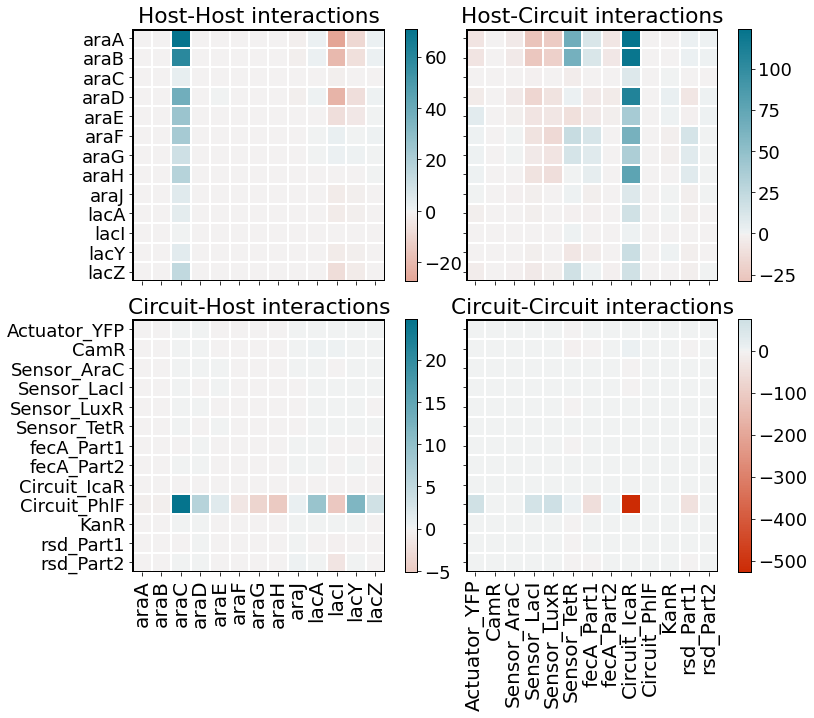

In [28]:
# visualize the results of the host and circuit impact analysis
ncircuitgenes = len(circuit_inds)
nhostgenes = len(my_inds)
Khh = Ktot[-nhostgenes:,-nhostgenes:]
Khc = Ktot[-nhostgenes:,0:ncircuitgenes]
Kch = Ktot[0:ncircuitgenes,-nhostgenes:]
Kcc = Ktot[0:ncircuitgenes,0:ncircuitgenes]
Klist = [Khh,Khc,Kch,Kcc]
xlablist = [my_genes,circuit_genes,my_genes,circuit_genes]
ylablist = [my_genes,my_genes,circuit_genes,circuit_genes]
titles = ['Host-Host interactions','Host-Circuit interactions','Circuit-Host interactions','Circuit-Circuit interactions']
fig,ax = plt.subplots(2,2,figsize=(13,10),sharey='row',sharex='col')
for ii,this_ax in enumerate(ax.reshape(-1)): 
    sns.heatmap(Klist[ii],cmap=my_cmap,center=0,ax=this_ax,xticklabels=xlablist[ii],yticklabels=ylablist[ii],
               linewidths=1.0,linecolor='white',square=True)
    this_ax.set_title(titles[ii])
    this_ax.set_yticklabels(ylablist[ii],fontsize=18)
    this_ax.set_xticklabels(xlablist[ii],fontsize=20)
    this_ax.axhline(y=0, color='k',linewidth=3)
    this_ax.axhline(y=Klist[ii].shape[0], color='k',linewidth=3)
    this_ax.axvline(x=0, color='k',linewidth=3)
    this_ax.axvline(x=Klist[ii].shape[1], color='k',linewidth=3)
    cax = fig.axes[-1]
    cax.set_frame_on(True)
    for spine in cax.spines.values():
        spine.set(visible=True, lw=1, edgecolor='k')
plt.subplots_adjust(wspace=-0.15,hspace=0.15)
# plt.tight_layout()
# plt.savefig(figDir+'fig3/impact_and_retroactivity_lac_ara.pdf',transparent=True,bbox_inches='tight',dpi=300)
plt.show()

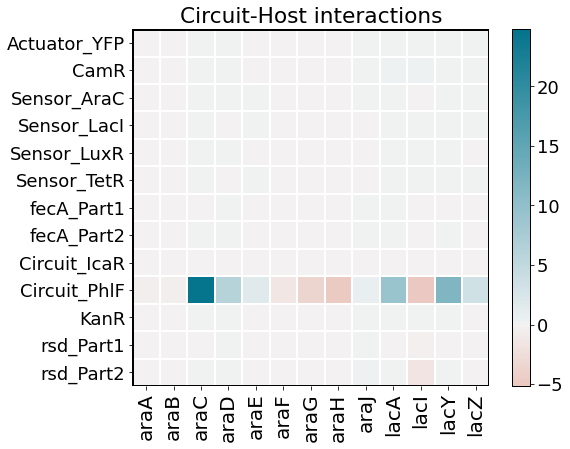

In [50]:
# blow-up of the circuit-host interactions
savefig = False
fig,ax = plt.subplots(1,1,figsize=(8,8))
sns.heatmap(Kch,cmap=my_cmap,center=0,xticklabels=my_genes,yticklabels=circuit_genes,ax=ax,
           linewidths=1.0,linecolor='white',square=True,cbar_kws={'shrink':0.82})
ax.set_title('Circuit-Host interactions')
ax.set_xticklabels(my_genes, fontsize = 20)
ax.set_yticklabels(circuit_genes, fontsize = 18)
ax.axhline(y=0, color='k',linewidth=3)
ax.axhline(y=Klist[ii].shape[0], color='k',linewidth=3)
ax.axvline(x=0, color='k',linewidth=3)
ax.axvline(x=Klist[ii].shape[1], color='k',linewidth=3)
cax = fig.axes[-1]
cax.set_frame_on(True)
for spine in cax.spines.values():
    spine.set(visible=True, lw=1, edgecolor='k')
if savefig: 
    plt.savefig(figDir+'fig5/host_to_circuit_impact_ara_lac.pdf',transparent=True,bbox_inches='tight',dpi=300)
plt.show()

#### NAND 1.0 Growth Curves

In [ ]:
import scipy.io
growth_curves_dir = '/Users/aqib/Desktop/UCSB/research/BCCL/structured-dmd/NAND_iterate/GrowthCurves/'
od = scipy.io.loadmat(growth_curves_dir+'NAND1_GCs.mat')
od = od['A']
t_od = np.linspace(0,24,len(od))

In [ ]:
def growth_stats(this_od):
    mean = this_od.mean(axis=1)
    std = this_od.std(axis=1)
    return mean, std
    
plt.figure(figsize=(6,5))
c1 = 'limegreen'
c2 = 'royalblue'
m,s = growth_stats(od[:,[9,21,33,45]]) # wt no induction
plt.plot(t_od,m,c=c1,label='Wild-type')  
plt.fill_between(t_od,m-s,m+s,color=c1,alpha=0.2)
m,s = growth_stats(od[:,[51,63,75,87]]) # nand + ara + iptg 
plt.plot(t_od,m,'--',c=c2,label='NAND strain')  
plt.fill_between(t_od,m-s,m+s,color=c2,alpha=0.2)

# m,s = growth_stats(od[:,[10,22,34,46]]) # wt + arabinose
# plt.plot(t_od,m,c='tab:orange', label='wild type + arabinose')  
# plt.fill_between(t_od,m-s,m+s,color='tab:orange',alpha=0.2)
# m,s = growth_stats(od[:,[57,69,81,93]]) # wt + IPTG
# plt.plot(t_od,m,c='tab:green',label='wild type + IPTG')  
# plt.fill_between(t_od,m-s,m+s,color='tab:green',alpha=0.2)
# m,s = growth_stats(od[:,[48,60,72,84]]) # phlf + arabinose (actually IPTG?)
# plt.plot(t_od,m,c='tab:red',label='PhlF + arabinose')  
# plt.fill_between(t_od,m-s,m+s,color='tab:red',alpha=0.2)
# m,s = growth_stats(od[:,[49,61,73,85]]) # icar + iptg 
# plt.plot(t_od,m,c='tab:blue', label='IcaR + IPTG')  
# plt.fill_between(t_od,m-s,m+s,color='tab:blue',alpha=0.2)

plt.vlines(5.0,0.0,1.4,linestyles='dashed',color='k')
plt.vlines(18.0,0.4,1.4,linestyles='dashed',color='k')
plt.legend(frameon=False,ncol=1,fontsize=16,loc='lower right')
plt.xlabel('Time (hours)')
plt.ylabel('OD (600 nm)')
# plt.savefig(figDir + 'fig1_actual/growth_curves.pdf',dpi=300,transparent=True,bbox_inches='tight')
plt.show()


#### networkx style graphic for figure 1 

In [ ]:
savefig = False

Ymean = (Yf_normed + Yp_normed).mean(axis=1)

def mapFromTo(x,a,b,c,d):
    y=(x-a)/(b-a)*(d-c)+c
    return y

node_sizes = mapFromTo(Ymean,Ymean.min(),Ymean.max(),100,500)


def edges(G):
    # getting the edge weights, making them positive and keep track of their original sign for coloring of edges
    edge_weights = list(nx.get_edge_attributes(G, "weight").values())
    edge_weights_nn = []
    edge_weights_sign = []
    edge_colors = []
    for ew in edge_weights: 
        if ew < 0:
            edge_weights_nn.append(np.abs(ew))
            edge_weights_sign.append('neg')
            edge_colors.append('lightcoral')
        else: 
            edge_weights_nn.append(ew)
            edge_weights_sign.append('pos')
            edge_colors.append('g')
    return edge_weights_nn, edge_colors

Knet = deepcopy(K.T)
Knet[np.abs(Knet)<1.0] = 0

print(len(np.nonzero(Knet)[0]))

G = nx.from_numpy_array(Knet,create_using=nx.DiGraph)

# relabel nodes
mapping = {}
for ii in range(Knet.shape[0]):
    mapping[ii] = my_genes[ii]
G = nx.relabel_nodes(G,mapping)
    
edge_weights, edge_colors = edges(G)
edge_weights = [3*(ee-np.min(edge_weights))/(np.max(edge_weights) - np.min(edge_weights)) for ee in edge_weights]


pos = nx.spring_layout(G,k=10.0,seed=0) # spring_layout, spectral_layout (eigenvectors not always easy to compute), random, shell
# pos = nx.kamada_kawai_layout(G)
# kamada_kawai_layout

plt.subplots(1,1,figsize=(3,3));

nx.draw_networkx_nodes(G,pos=pos,node_size=node_sizes,edgecolors='k',linewidths=1.5,node_color='white',alpha=0.95)
nx.draw_networkx_edges(G,pos=pos,arrowsize=10,width=edge_weights,edge_color=edge_colors,alpha=1,
                      connectionstyle='arc3,rad=0.1')
# nx.draw_networkx_labels(G,pos=pos,font_size=4)

shift = 0.2
for gene in pos: 
    x,y = pos[gene][0], pos[gene][1]
    if x >= 0.0 and y >= 0.0:
        x, y = x + shift, y + shift
    elif x < 0.0 and y < 0.0:
        x, y = x - 1.5*shift, y - shift
    elif x < 0.0 and y >= 0.0:
        x, y = x - shift, y + shift
    elif x >= 0.0 and y < 0.0:
        x, y = x + 1.5*shift, y - shift
    plt.text(x,y,s=gene,bbox=dict(facecolor='gray', alpha=0.2),horizontalalignment='center',fontsize=10)


plt.axis('equal')
plt.axis('off')

if savefig: 
    plt.savefig(figDir + 'fig1_actual/directed_graph_ara_lac.pdf',dpi=300,bbox_inches='tight',transparent=True)
# plt.close()    
plt.show()

#### 3d bar chart of gene expression at two timepoints

In [ ]:
def expr_3dbar(Y,gene_names,theme,cond='',savefig=False,figname=''):
    lx = Y.shape[1]
    ly = Y.shape[0]
    xpos = np.arange(0,lx,1)
    ypos = np.arange(0,ly,1)
    xpos, ypos = np.meshgrid(xpos+0.25, ypos+0.25)
    xpos = xpos.flatten()   # Convert positions to 1D array
    ypos = ypos.flatten()
    zpos = np.zeros(lx*ly)
    dx = 0.5 * np.ones_like(zpos)
    dy = dx.copy()
    dz = Y.flatten()
    
    bar_colors = theme * ly
    if Y.shape[1] == 8:
        bar_colors = ['navajowhite','orange','darkorange','tab:orange',
                      'lightskyblue','cornflowerblue','royalblue','blue'] * ly
    elif Y.shape[1] == 6: 
        bar_colors = ['orange','darkorange','tab:orange',
                      'lightskyblue','cornflowerblue','royalblue'] * ly
        

    fig = plt.figure(figsize=(7,7))
    ax = Axes3D(fig,azim=-60,elev=30,proj_type='persp')
    ax.bar3d(xpos,ypos,zpos, dx, dy, dz,color=bar_colors,alpha=0.8)

    ax.yaxis._axinfo['tick']['linewidth']={True: 0.0, False: 0.0} # remove tick marks from y-axis since it's buggy 
    if Y.shape[1] == 8: 
        ax.w_xaxis.set_ticks([2,6])
    elif Y.shape[1] == 6:
        ax.w_xaxis.set_ticks([1.5,4.5])
    elif Y.shape[1] == 4: 
        ax.w_xaxis.set_ticks([2])
    elif Y.shape[1] == 3: 
        ax.w_xaxis.set_ticks([1.5])
    
    ax.w_xaxis.set_ticklabels(column_names,fontsize=24)    
    ax.w_yaxis.set_ticks(np.arange(1.75,len(gene_names)+1.75,1))
    ax.w_yaxis.set_ticklabels(gene_names,fontsize=16,)
        
    ax.tick_params(axis="y",direction="out", pad=5)    
#     ax.set_xlabel('Time (hours)',labelpad=10)
    ax.set_zlabel('Expression \n (TPM)',labelpad=20)

    # Get rid of colored axes planes
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    ax.set_box_aspect(aspect = (0.75,1.75,0.75))
    
    if 'wt11' in cond or 'nand11' in cond:        
        ax.ticklabel_format(style='sci', axis='z', scilimits=(0,0), useMathText=True)
        ax.zaxis.get_offset_text().set_visible(False)
        if 'wt11_5' in cond:            
            ax.text(4,10,0.155e4,'$\\times\\mathdefault{10^{4}}\\mathdefault{}$') # for wt11
        elif 'wt11_18' in cond: 
            ax.text(4,10,1.9e4,'$\\times\\mathdefault{10^{4}}\\mathdefault{}$') # for wt11
        elif 'nand11_5' in cond:
            ax.text(5.2,10,0.225e4,'$\\times\\mathdefault{10^{4}}\\mathdefault{}$') # for nand11
        elif 'nand11_18' in cond:
            ax.text(5.2,10,1.65e4,'$\\times\\mathdefault{10^{4}}\\mathdefault{}$') # for nand11

    if savefig: 
        plt.savefig(figDir+figname,dpi=300,transparent=True,bbox_inches='tight')
    plt.show()
##################################################################################################################
    
# color palette for bars
blue_colors = ['lightskyblue','cornflowerblue','royalblue','blue']
orange_colors = ['navajowhite','orange','darkorange','tab:orange']
green_colors = ['lightgreen','limegreen','forestgreen','darkgreen']
red_colors = ['lightcoral','red','tab:red','darkred']
purple_colors = ['plum','orchid','tab:purple','rebeccapurple']

    
# always grab gene indices (and row names) using:
Yp = snapshot_dict['wt'][TEMP]['00']['Yp'][my_inds] # don't change
Yf = snapshot_dict['wt'][TEMP]['00']['Yf'][my_inds] # don't change
Y = np.hstack((Yp,Yf))
sorted_inds = np.argsort(Y.mean(axis=1))
row_names = [my_genes[ii] for ii in sorted_inds]
# row_names = deepcopy(my_genes)


DOSAVE = True
######################################################################
Yp = snapshot_dict['wt'][TEMP]['00']['Yp'][my_inds]
Yf = snapshot_dict['wt'][TEMP]['00']['Yf'][my_inds]
# Y = np.hstack((Yp[my_inds],Yf[my_inds]))[sorted_inds]
Yp, Yf = Yp[sorted_inds], Yf[sorted_inds]
cond = 'wt00_5'
figname = 'fig1_actual/'+cond+'_bars.pdf'
column_names = ['5 hours']
expr_3dbar(Yp,row_names,blue_colors[:Yp.shape[1]],cond=cond,savefig=DOSAVE,figname=figname)
cond = 'wt00_18'
figname = 'fig1_actual/'+cond+'_bars.pdf'
column_names = ['18 hours']
expr_3dbar(Yf,row_names,cond=cond,theme=blue_colors[:Yp.shape[1]],savefig=DOSAVE,figname=figname)

######################################################################
Yp = snapshot_dict['wt'][TEMP]['11']['Yp'][my_inds]
Yf = snapshot_dict['wt'][TEMP]['11']['Yf'][my_inds]
# Y = np.hstack((Yp[my_inds],Yf[my_inds]))[sorted_inds]
Yp, Yf = Yp[sorted_inds], Yf[sorted_inds]
cond = 'wt11_5'
figname = 'fig1_actual/'+cond+'_bars.pdf'
column_names = ['5 hours']
expr_3dbar(Yp,row_names,theme=orange_colors[:Yp.shape[1]],cond=cond,savefig=DOSAVE,figname=figname)
cond = 'wt11_18'
figname = 'fig1_actual/'+cond+'_bars.pdf'
column_names = ['18 hours']
expr_3dbar(Yf,row_names,theme=orange_colors[:Yp.shape[1]],cond=cond,savefig=DOSAVE,figname=figname)

######################################################################
Yp = snapshot_dict['icar'][TEMP]['00']['Yp'][my_inds]
Yf = snapshot_dict['icar'][TEMP]['00']['Yf'][my_inds]
# Y = np.hstack((Yp[my_inds],Yf[my_inds]))[sorted_inds]
Yp, Yf = Yp[sorted_inds], Yf[sorted_inds]
cond = 'icar00_5'
figname = 'fig1_actual/'+cond+'_bars.pdf'
column_names = ['5 hours']
expr_3dbar(Yp,row_names,theme=green_colors[:Yp.shape[1]],cond=cond,savefig=DOSAVE,figname=figname)
cond = 'icar00_18'
figname = 'fig1_actual/'+cond+'_bars.pdf'
column_names = ['18 hours']
expr_3dbar(Yf,row_names,theme=green_colors[:Yp.shape[1]],cond=cond,savefig=DOSAVE,figname=figname)

######################################################################
Yp = snapshot_dict['phlf'][TEMP]['00']['Yp'][my_inds]
Yf = snapshot_dict['phlf'][TEMP]['00']['Yf'][my_inds]
# Y = np.hstack((Yp[my_inds],Yf[my_inds]))[sorted_inds]
Yp, Yf = Yp[sorted_inds], Yf[sorted_inds]
cond = 'phlf00_5'
figname = 'fig1_actual/'+cond+'_bars.pdf'
column_names = ['5 hours']
expr_3dbar(Yp,row_names,theme=red_colors[:Yp.shape[1]],cond=cond,savefig=DOSAVE,figname=figname)
cond = 'phlf00_18'
figname = 'fig1_actual/'+cond+'_bars.pdf'
column_names = ['18 hours']
expr_3dbar(Yf,row_names,theme=red_colors[:Yp.shape[1]],cond=cond,savefig=DOSAVE,figname=figname)

######################################################################
Yp = snapshot_dict['nand'][TEMP]['11']['Yp'][my_inds]
Yf = snapshot_dict['nand'][TEMP]['11']['Yf'][my_inds]
# Y = np.hstack((Yp[my_inds],Yf[my_inds]))[sorted_inds]
Yp, Yf = Yp[sorted_inds], Yf[sorted_inds]
cond = 'nand11_5'
figname = 'fig1_actual/'+cond+'_bars.pdf'
column_names = ['5 hours']
expr_3dbar(Yp,row_names,theme=purple_colors[:Yp.shape[1]],cond=cond,savefig=DOSAVE,figname=figname)
cond = 'nand11_18'
figname = 'fig1_actual/'+cond+'_bars.pdf'
column_names = ['18 hours']
expr_3dbar(Yf,row_names,theme=purple_colors[:Yp.shape[1]],cond=cond,savefig=DOSAVE,figname=figname)



#### Robust DMD graphic

In [6]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [7]:
def get_cov_ellipsoid(cov, mu=np.zeros((3)), nstd=3):
    """
    Return the 3d points representing the covariance matrix
    cov centred at mu and scaled by the factor nstd.
    Plot on your favourite 3d axis. 
    Example 1:  ax.plot_wireframe(X,Y,Z,alpha=0.1)
    Example 2:  ax.plot_surface(X,Y,Z,alpha=0.1)
    """
    assert cov.shape==(3,3)

    # Find and sort eigenvalues to correspond to the covariance matrix
    eigvals, eigvecs = np.linalg.eig(cov)
    idx = np.sum(cov,axis=0).argsort()
    eigvals_temp = eigvals[idx]
    idx = eigvals_temp.argsort()
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:,idx]

    # Set of all spherical angles to draw our ellipsoid
    n_points = 100
    theta = np.linspace(0, 2*np.pi, n_points)
    phi = np.linspace(0, np.pi, n_points)

    # Width, height and depth of ellipsoid
    rx, ry, rz = nstd * np.sqrt(eigvals)

    # Get the xyz points for plotting
    # Cartesian coordinates that correspond to the spherical angles:
    X = rx * np.outer(np.cos(theta), np.sin(phi))
    Y = ry * np.outer(np.sin(theta), np.sin(phi))
    Z = rz * np.outer(np.ones_like(theta), np.cos(phi))

    # Rotate ellipsoid for off axis alignment
    old_shape = X.shape
    # Flatten to vectorise rotation
    X,Y,Z = X.flatten(), Y.flatten(), Z.flatten()
    X,Y,Z = np.matmul(eigvecs, np.array([X,Y,Z]))
    X,Y,Z = X.reshape(old_shape), Y.reshape(old_shape), Z.reshape(old_shape)
   
    # Add in offsets for the mean
    X = X + mu[0]
    Y = Y + mu[1]
    Z = Z + mu[2]
    
    return X,Y,Z

In [8]:
Yp = snapshot_dict['wt'][TEMP]['11']['Yp'][my_inds]#[my_inds][-3:]
Yf = snapshot_dict['wt'][TEMP]['11']['Yf'][my_inds]#[my_inds][-3:]
Yp, Yf = apply_biased_StandardScaler(Yp,Yf)
Y = np.hstack((Yp,Yf))

U,s,Vh = np.linalg.svd(Y)
Yproj = np.diag(s)[:3,:3] @ Vh[:3,:]
Yp_proj, Yf_proj = Yproj[:,[0,1,2]], Yproj[:,[3,4,5]]

mup = np.mean(Yp_proj,axis=1)
muf = np.mean(Yf_proj,axis=1)
Covp = np.cov(Yp_proj) + 1e-12*np.eye(Yp_proj.shape[0]) # adding noise to diagonal so eigenvalues are not negative by numerical error
Covf = np.cov(Yf_proj) + 1e-12*np.eye(Yf_proj.shape[0])

nstd = 10 # 95% confidence interval when equal to 2

X1,Y1,Z1 = get_cov_ellipsoid(Covp, mup, nstd)
X2,Y2,Z2 = get_cov_ellipsoid(Covf, muf, nstd)

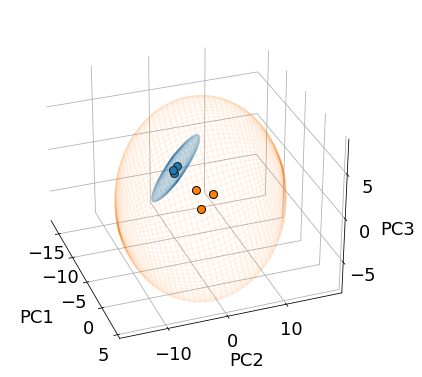

In [9]:
savefig = False

fig = plt.figure(figsize=(5,5))
ax = Axes3D(fig,azim=-20,elev=30,proj_type='persp')
ax.set_xlabel('PC1',labelpad=20)
ax.set_ylabel('PC2',labelpad=10)
ax.set_zlabel('PC3',labelpad=10)

ax.plot_wireframe(X1,Y1,Z1, color='tab:orange', alpha=0.075)
ax.plot(Yp_proj[0,:],Yp_proj[1,:],Yp_proj[2,:],'o',c='tab:orange',ms=8,mec='k')
ax.plot_wireframe(X2,Y2,Z2, color='tab:blue', alpha=0.075)
ax.plot(Yf_proj[0,:],Yf_proj[1,:],Yf_proj[2,:],'o',c='tab:blue',ms=8,mec='k')

# Get rid of colored axes planes
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

if savefig: 
    plt.savefig(figDir + 'fig2/PC_ellipsoid_wt11.pdf',dpi=300,bbox_inches='tight',transparent=True)

plt.show()

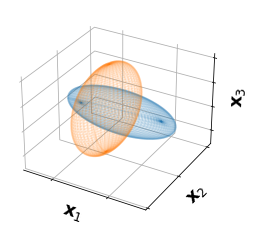

In [76]:
# Setup the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel(r'$\mathbf{x}_1$',labelpad=-5)
ax.set_ylabel(r'$\mathbf{x}_2$',labelpad=-5)
ax.set_zlabel(r'$\mathbf{x}_3$',labelpad=-5)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
#########################################################
## Generate datasets s1 and s2
#########################################################
# s1
mu1 = np.random.random((3)) * 5
cov1 = np.diag((1,1,1))
s1 = np.random.multivariate_normal(mu1, cov1, (200))
# ax.scatter(s1[:,0],s1[:,1],s1[:,2], c='r')

# s2
mu2 = np.random.random((3)) 
cov2 = np.diag((0.1,20,5))
s2 = np.random.multivariate_normal(mu2, cov2, (200))
# ax.scatter(s2[:,0],s2[:,1],s2[:,2], c='b')

#########################################################
## Process data and plot ellipsoid
#########################################################
nstd = 2    # 95% confidence interval
# s1
mu1_ = np.mean(s1, axis=0)
cov1_ = np.cov(s1.T)
X1,Y1,Z1 = get_cov_ellipsoid(cov1_, mu1_, nstd)
ax.plot_wireframe(X1,Y1,Z1, color='tab:blue', alpha=0.1)

# s2
mu2_ = np.mean(s2, axis=0)
cov2_ = np.cov(s2.T)
X2,Y2,Z2 = get_cov_ellipsoid(cov2_, mu2_, nstd)
ax.plot_wireframe(X2,Y2,Z2, color='tab:orange', alpha=0.1)

# Get rid of colored axes planes
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# plt.savefig('/Users/aqib/desktop/gram_ellipsoid.pdf',dpi=300,bbox_inches='tight',transparent=True)

plt.show()

#### volcano plots if modeling positive genes from DE analysis

In [90]:
res_dict = {}
res_dict['nand5_wt5'] = pd.read_csv(res_dir_list[0])
res_dict['nand18_wt18'] = pd.read_csv(res_dir_list[1])

In [91]:
# get the genes in each comparison that have |FC| > 1.25 and padj < 0.05
res_dict_filter = {}
for key in res_dict: 
    res_tmp = res_dict[key].loc[res_dict[key].padj < 0.05]
    res_tmp_tmp = res_tmp.loc[np.abs(res_tmp.log2FoldChange) >= np.log2(2)] 
    res_dict_filter[key] = res_tmp_tmp
    print(len(res_tmp_tmp))

# take union of the genes in each set
genes_DE = set() # set of all differentially expressed genes
for key in res_dict: 
    genes_DE = genes_DE.union(res_dict_filter[key].iloc[:,0])
genes_DE = list(genes_DE)
print(len(genes_DE))

581
169
695


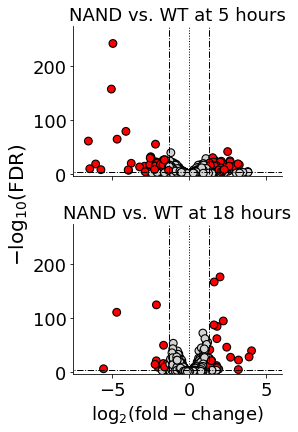

In [92]:
# volcano plots
savefig = False

fig,axs = plt.subplots(2,1,figsize=(4,6),sharex=True,sharey=True)
titles = ['NAND vs. WT at 5 hours', 'NAND vs. WT at 18 hours']
cnt = 0
for comp,ax in zip(res_dict,axs.reshape(-1)):
    ax.set_title(titles[cnt],fontsize=18)
    these_colors = ['lightgray'] * len(res_dict[comp])
    for ii,elem in enumerate(res_dict[comp].padj<p_thresh):
        if elem == True and (np.abs(res_dict[comp].log2FoldChange)[ii] >= np.log2(fc_thresh)):
            these_colors[ii] = 'red'
    ax.scatter(res_dict[comp].log2FoldChange,-np.log10(res_dict[comp].padj),s=60,c=these_colors,edgecolors='k',
              linewidths=1.1)
    ax.hlines(-np.log10(p_thresh),-8,8,color='k',linewidth=1,linestyles='dashdot')
    ax.vlines(np.log2(fc_thresh),0,275,color='k',linewidth=1,linestyles='dashdot')
    ax.vlines(-np.log2(fc_thresh),0,275,color='k',linewidth=1,linestyles='dashdot')
    ax.vlines(0,0,275,color='k',linewidth=1,linestyles='dotted')
    cnt += 1
axs[0].set_xlim(-7.5,6)
axs[0].set_ylim(-5,275)
# ax.set_xscale('log')
fig.text(0.27,0.0,r'$\log_2(\mathrm{fold-change})$',fontsize=18) # xlabel
fig.text(-0.02,0.37,r'$-\log_{10}(\mathrm{FDR})$',rotation='vertical',fontsize=20) # ylabel
plt.tight_layout()
if savefig: 
    plt.savefig(figDir+'fig4/volcanoplots.pdf',dpi=300,transparent=True,bbox_inches='tight')  
plt.show()